In [ ]:
!pip install dynamo
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seborn
!pip insatll gprofiler

# Running RNA Velocity with Dynamo
This tutorial utilizes prior information to correct velocity embeddings, but can be adjusted if lineage is unknown

This should be used when the developmental order of cell states are known

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot
import matplotlib.pyplot as plt
import sys
import os
import dynamo as dyn

In [3]:
import random
random.seed(23)

## Read in Data

In [4]:
adata = dyn.read('chip1-4_preprocessed.h5ad')
adata = adata[adata.obs['origin'] != '231',:]
adata = adata[adata.obs['chip'] == 'c1_231',:]

/home/bstrope/.local/lib/python3.10/site-packages/anndata/__init__.py:56: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


## Preprocess Data

1. Preprocess genes and filter out those that are lowly expressed
2. Filter cells that don't pass QC metrics (low gene counts)
3. Run PCA and UMAP on the filtered data

After loading data, you are ready to performs some preprocessing. You can run the recipe_monocle function that uses similar but generalized strategy from Monocle 3 to normalize all datasets in different layers (the spliced and unspliced or new, i.e. metabolic labelled, and total mRNAs or others), followed by feature selection, log1p transformation of the data and PCA dimension reduction. recipe_monocle also does a few additionl steps, which include:

converting ensemble gene names to gene official name and set them as .var_names if needed.

calculating number of expressed genes (nGenes), total expression values (nCounts), percentage of total mitochondria gene values (pMito) for each cell and save them to .obs.

detecting your experiment type (conventional scRNA-seq or time-resolved metabolic labeling datasets) and set certain proper layers (i.e. ignore some unconventional layers provided by the users) to be size factor normalized, log1p transformed, etc.

makings cell (.obs_names) and gene names (.var_names) unique.

savings data in .layers as csr sparse matrix for the purpose of memory efficency.

adding collapsed new, total and unspliced, spliced layers from the uu, ul, su, sl layers of a metabolic labeling experiment.

calculating each cell’s cell cycle stage score.

calculating new to total ratio (ntr) for each gene and cell.

In [5]:
preprocessor = dyn.pp.Preprocessor(cell_cycle_score_enable=True)
preprocessor.config_monocle_recipe(adata)
preprocessor.filter_cells_by_outliers_kwargs["keep_filtered"] = True
preprocessor.preprocess_adata_monocle(adata)

|-----> Running monocle preprocessing pipeline...


/home/bstrope/.local/lib/python3.10/site-packages/dynamo/preprocessing/Preprocessor.py:243: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["pp"] = {}


|-----------> filtered out 0 outlier cells
|-----------> filtered out 25980 outlier genes
|-----> PCA dimension reduction
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> computing cell phase...
|-----> [Cell Phase Estimation] completed [51.2517s]
|-----> [Cell Cycle Scores Estimation] completed [0.0867s]
|-----> [Preprocessor-monocle] completed [9.0230s]


/home/bstrope/.local/lib/python3.10/site-packages/dynamo/preprocessing/cell_cycle.py:461: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_cycle_scores["cell_cycle_order"] = cell_cycle_scores.groupby("cell_cycle_phase").cumcount()
/home/bstrope/.local/lib/python3.10/site-packages/dynamo/preprocessing/cell_cycle.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cell_cycle_scores["cell_cycle_order"] = cell_cycle_scores.groupby("cell_cycle_phase", group_keys=False)[


## Perform Dynamics

RNA velocity (
 
) for conventional scRNA-seq is just 
 
 (while 
 is the unspliced or spliced mRNA respectively.
 is splicing rate and is generally assumed to be 1 while 
 is degration rate and is what we need to estimate). To estimate gamma for conventional scRNA-seq data, we provided three approaches deterministic, stochastic and negbin. The first one is equivalent to velocyto’s implementation or scvelo’s deterministic mode while the second one scvelo’s stochastic mode. Negative binomal is a novel method from us that relies on the negative binomial formulation of gene exrpession distribution at steady state. Furthermore, we support multi-core parallelism of gamma estimation so you can analyze your large single-cell datasets with dynamo efficiently.

dyn.tl.dynamics function combines gamma estimation and velocity calculation in one-shot. Furthermore, it implicitly calls dyn.tl.moments first, and then performs the following steps:

checks the data you have and determines the experimental type automatically, either the conventional scRNA-seq, kinetics, degradation or one-shot single-cell metabolic labelling experiment or the CITE-seq or REAP-seq co-assay, etc.

learns the velocity for each feature gene using either the original deterministic model based on a steady-state assumption from the seminal RNA velocity work or a few new methods, including the stochastic (default) or negative binomial method for conventional scRNA-seq or kinetic, degradation or one-shot models for metabolic labeling based scRNA-seq.

Those later methods are based on moment equations which basically considers both mean and uncentered variance of gene expression. The moment based models require calculation of the first and second moments of the expression data, which relies on the cell nearest neighbours graph, constructed in the reduced PCA space from the spliced or total mRNA expression.



In [6]:
dyn.tl.dynamics(adata, model='stochastic', cores=3)

|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----> [moments calculation] completed [7.6062s]


AnnData object with n_obs × n_vars = 511 × 40854
    obs: 'chip', 'cell_ID', 'origin', 'mouse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_pca', 'cell_cycle_scores'
    varm: 'vel_params'
    layers: 'ambiguous', 'matrix', 'spanning', 'spliced', 'unspliced', 'X_spli

Next we perform dimension reduction (by default, UMAP) and visualize the UMAP embedding of cells. The provided Cell_type information is also used to color cells. 

|-----> retrieve data for non-linear dimension reduction...
|-----> [UMAP] using X_pca with n_pca_components = 30
|-----> <insert> X_umap to obsm in AnnData Object.
|-----> [UMAP] completed [2.4408s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering origin by stack threshold when stacking color because it is not a numeric type


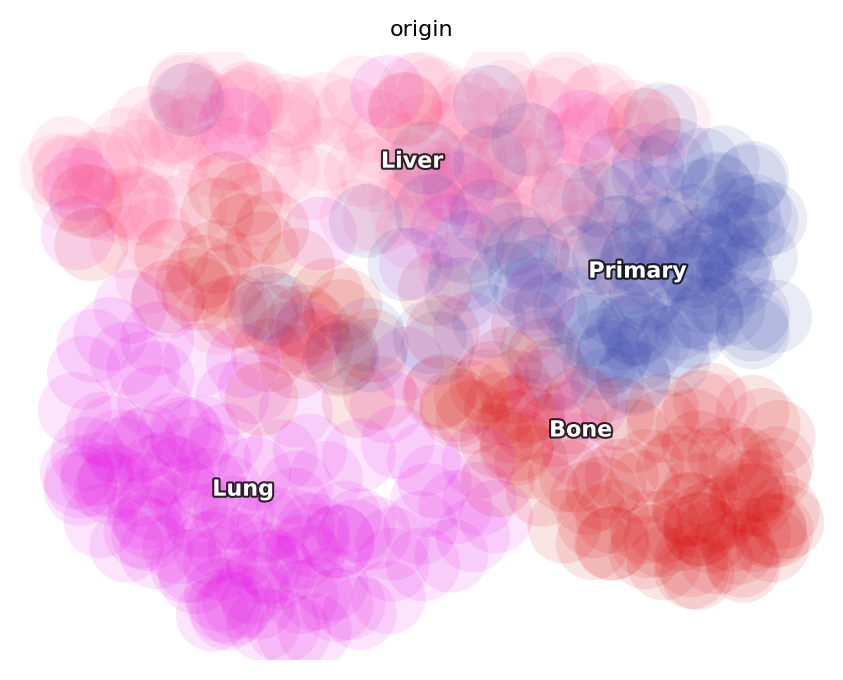

In [7]:
dyn.tl.reduceDimension(adata)
dyn.pl.umap(adata, color='origin')

In [8]:
dyn.tl.cell_velocities(adata, method='pearson',basis = 'pca', other_kernels_dict={'transform': 'sqrt'})
dyn.tl.cell_velocities(adata, method='pearson', basis = 'umap',other_kernels_dict={'transform': 'sqrt'})

|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 43.4442%

/home/bstrope/.local/lib/python3.10/site-packages/dynamo/tools/utils.py:2605: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(vel_params_df.gamma_r2.values is None) or np.all(vel_params_df.gamma_r2.values == ""):


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3320s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1247s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1179s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 511 × 40854
    obs: 'chip', 'cell_ID', 'origin', 'mouse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'umap_fit', 'origin_colors', 'grid_velocity_pca', 'grid_velocity_umap'
    obsm: 'X_scVI', 'X_scVI_MDE', 'X_pca', 'cell_cycle_sc

#### Use the following two lines of code when lineage dictionary is known

Kinetic estimation of the conventional scRNA-seq and metabolic labeling based scRNA-seq is often tricky and has a lot pitfalls. Sometimes you may even observed undesired backward vector flow. You can evaluate the confidence of gene-wise velocity via:

In [9]:
dyn.tl.gene_wise_confidence(adata, group='origin', lineage_dict={'Primary': ['Lung','Liver']})

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:05, 335.26it/s]


In [10]:
dyn.tl.confident_cell_velocities(adata, group='origin', basis = 'pca',lineage_dict={'Primary': ['Lung','Liver']})
dyn.tl.confident_cell_velocities(adata, group='origin', basis = 'umap',lineage_dict={'Primary': ['Lung','Liver']})

calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:05, 346.39it/s]


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.4802s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1382s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


calculating gene velocity vectors confidence based on phase portrait location with priors of progenitor/mature cell types: 2000it [00:05, 344.45it/s]


|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%|-----> [calculating transition matrix via pearson kernel with sqrt transform.] completed [0.3784s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.1107s]
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 511 × 40854
    obs: 'chip', 'cell_ID', 'origin', 'mouse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition', 'avg_prog_confidence', 'avg_mature_confidence', 'avg_confidence', 'confident_genes'
    uns: 'pp', 'velocyto_SVR', 'feature_selection', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'cell_phase_order', 'cell_phase_genes', 'vel_params_names', 'dynamics', 'neighbors', 'umap_fit', 'origin_colors', 'grid_velocity

#### Plotting of Phase Portraits

In the following, let us have a look at the phase diagram of some genes that have velocity calculated

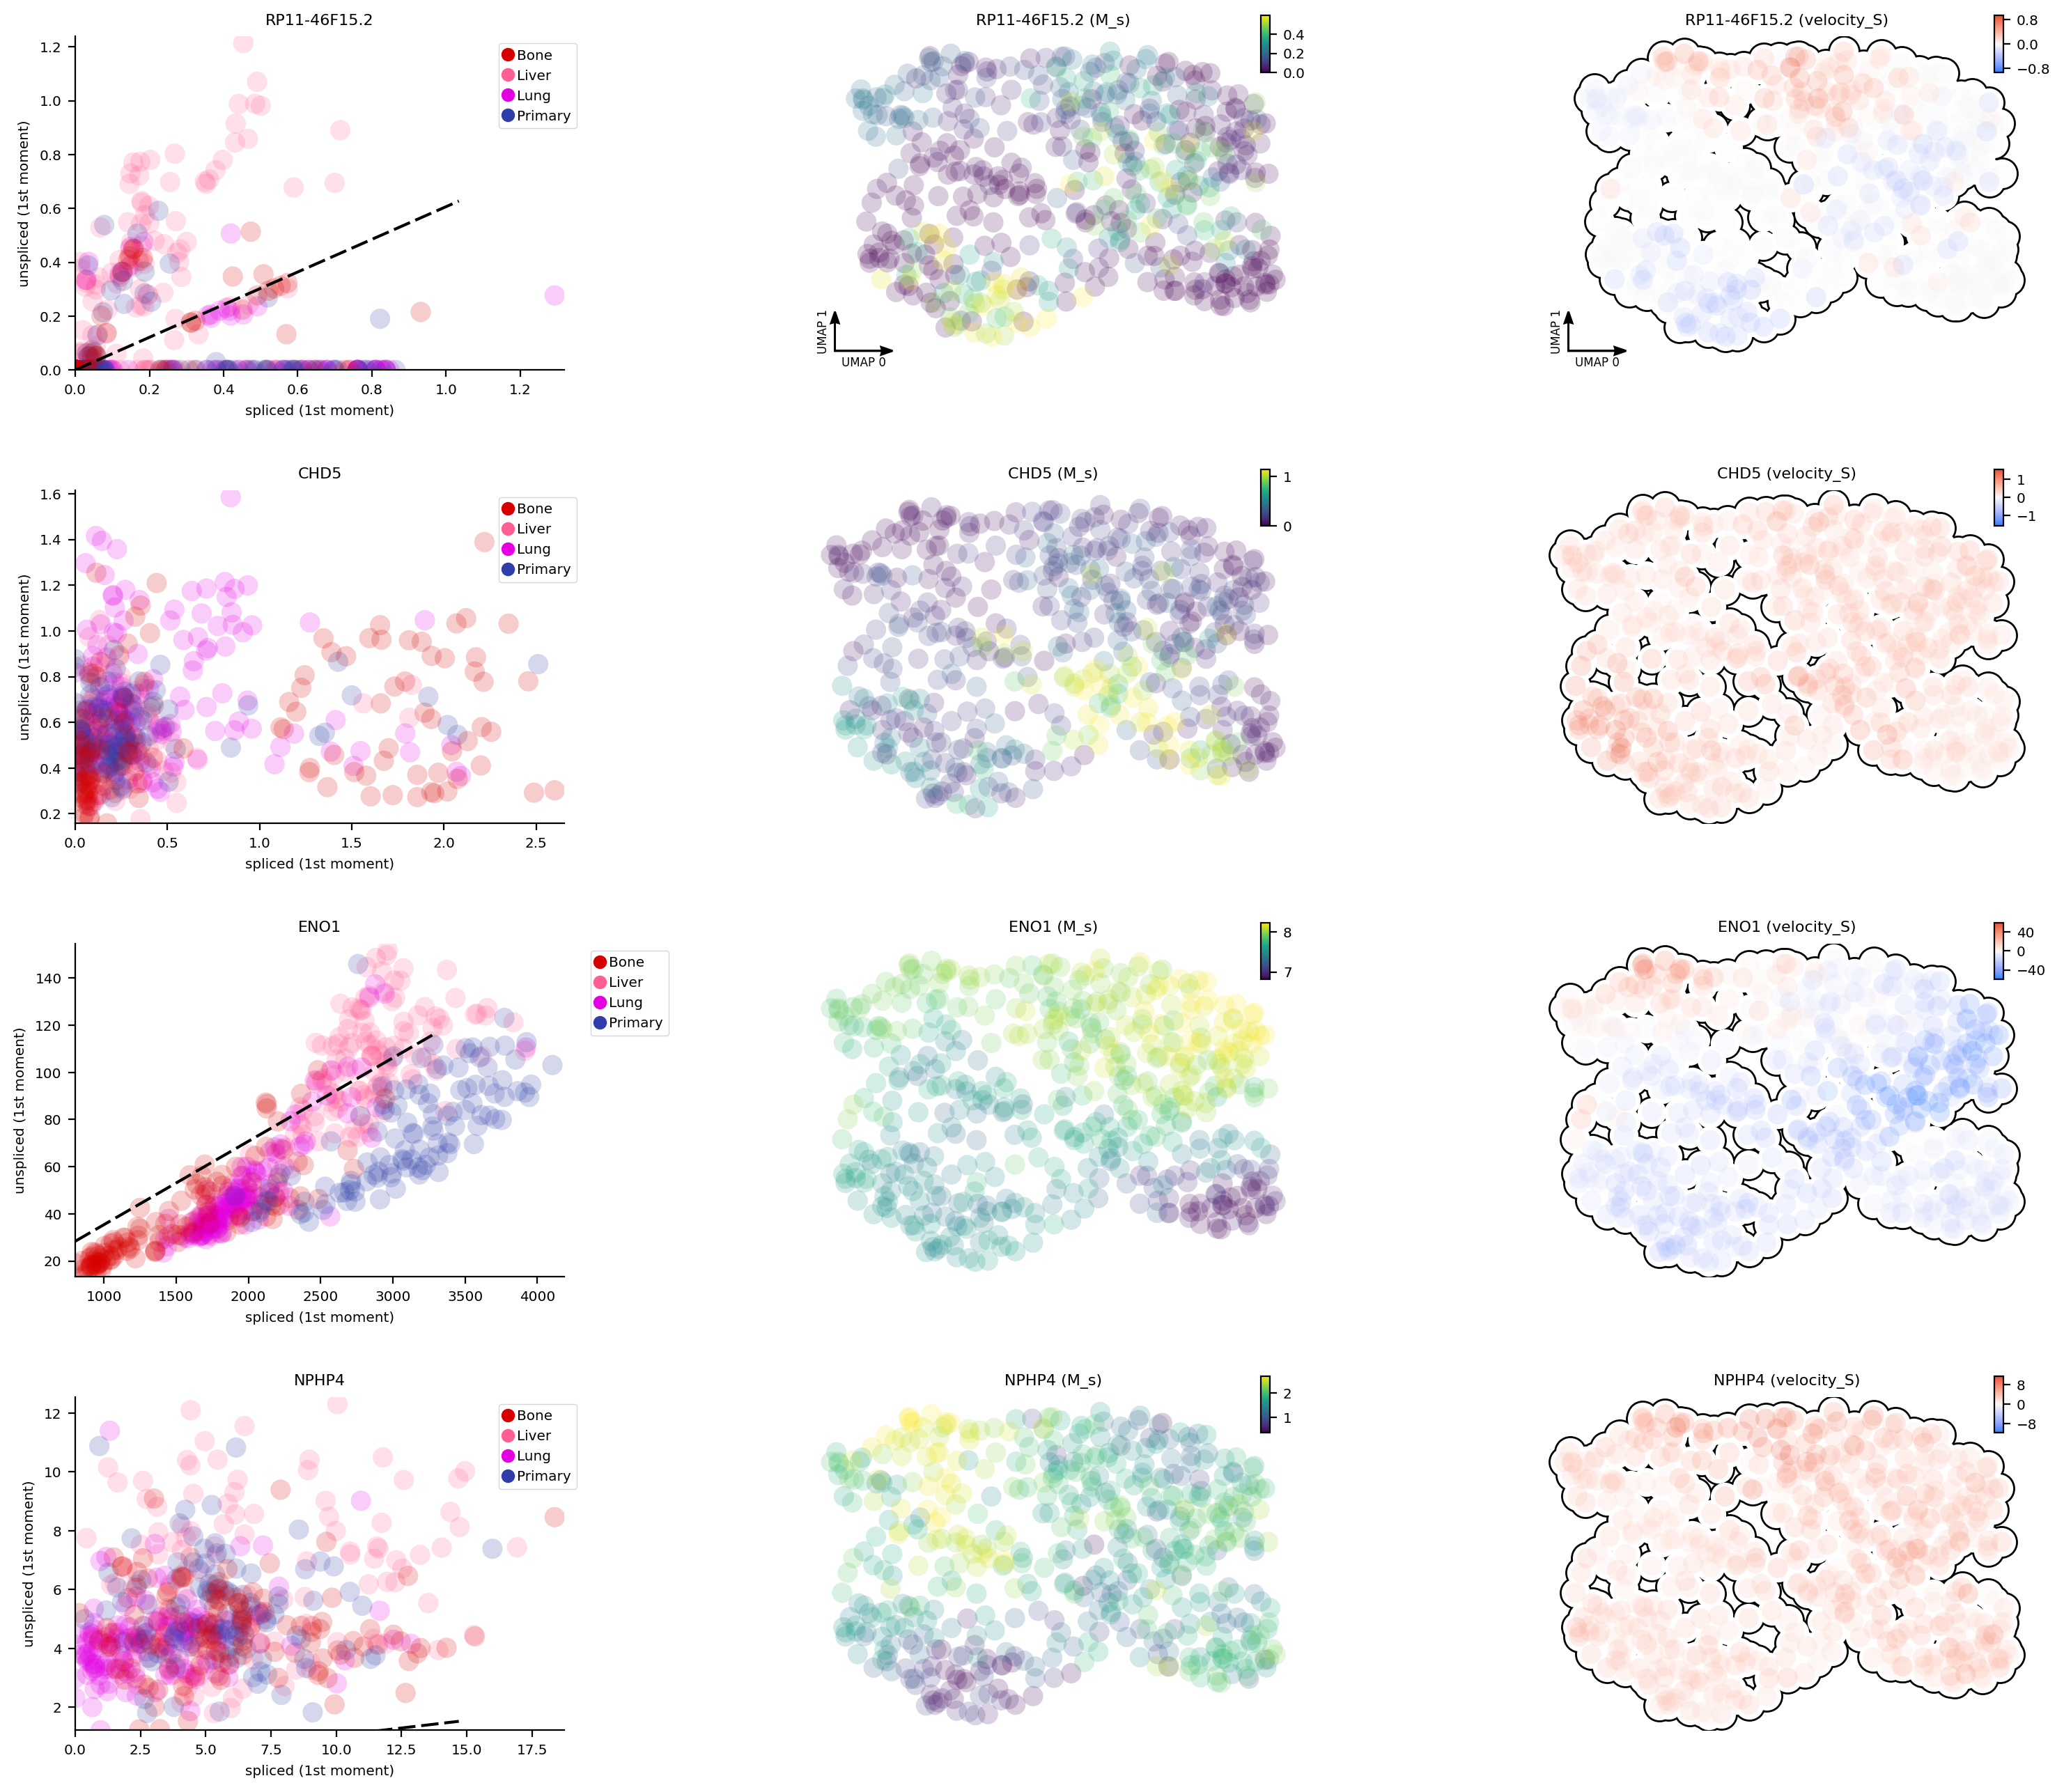

In [11]:
dyn.pl.phase_portraits(adata, genes=adata.var_names[adata.var.use_for_dynamics][:4], figsize=(6, 4), color='origin')

#### Visualize Velocity Embeddings in Low Dimension UMAP
 The projection involves calculating a transition matrix between cells for local averaging of velocity vectors in low dimension. There are three methods to calculate the transition matrix, either kmc, cosine, pearson. kmc

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering origin by stack threshold when stacking color because it is not a numeric type


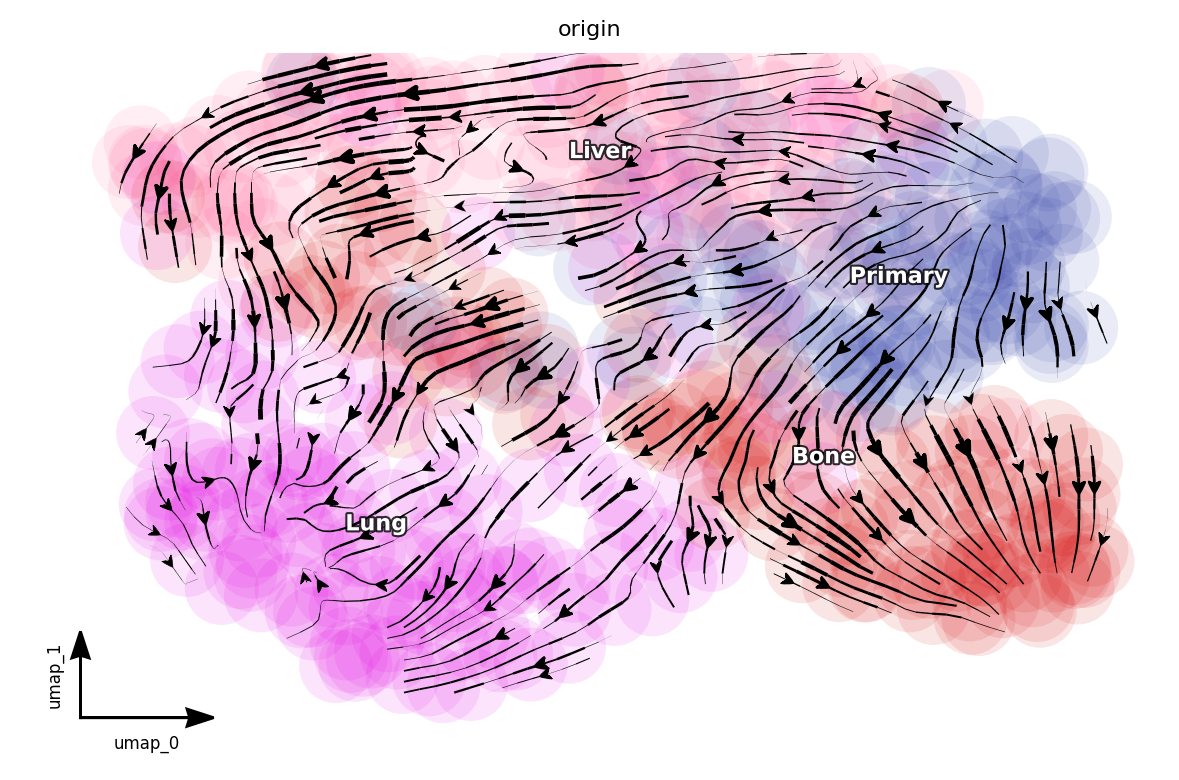

|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----------> plotting with basis key=X_umap
|-----------> skip filtering origin by stack threshold when stacking color because it is not a numeric type
Saving figure to chip1/streamline_dyn_savefig.png...
Done


In [12]:
dyn.pl.streamline_plot(adata, color=['origin'], basis='umap', show_legend='on data', show_arrowed_spines=True)
dyn.pl.streamline_plot(adata, color=['origin'], basis='umap', show_legend='on data', show_arrowed_spines=True,save_show_or_return='save',
                      save_kwargs={'path' :'chip1/','prefix':'streamline','ext':'png'})

#### Calculate Vector Fields
In classical physics, including fluidics and aerodynamics, velocity and acceleration vector fields are used as fundamental tools to describe motion or external force of objects, respectively. In analogy, RNA velocity or protein accelerations estimated from single cells can be regarded as sparse samples in the velocity (La Manno et al. 2018) or acceleration vector field (Gorin, Svensson, and Pachter 2019) that defined on the gene expression space.

In general, a vector field can be defined as a vector-valued function f that maps any points (or cells’ expression state) x in a domain Ω with D dimension (or the gene expression system with D transcripts / proteins) to a vector y (for example, the velocity or acceleration for different genes or proteins), that is f(x) = y.

In [13]:
dyn.vf.VectorField(adata, basis='umap', M=1000, pot_curl_div=True)
dyn.vf.VectorField(adata, basis='pca', M=1000, pot_curl_div=True)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [SparseVFC] completed [9.0837s]
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and return_nbrs=True
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected
|-----> [ddhodge completed] completed [0.5958s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 511/511 [00:00<00:00, 13718.11it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 1/1 [00:00<00:00, 23.08it/s]

|-----> [VectorField] completed [9.8191s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected


|-----> [SparseVFC] completed [1.0016s]
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and return_nbrs=True
|-----------> calculating neighbor indices...
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> [ddhodge completed] completed [0.9915s]
|-----> Computing divergence...


Calculating divergence: 100%|██████████| 1/1 [00:00<00:00, 11.16it/s]

|-----> [VectorField] completed [2.1198s]


## Least Actionable Path 
The least action path (LAP) is a principled method that has previously been used in theoretical efforts to predict the most probable path a cell will follow during fate transition. Specifically, the optimal path between any two cell states

The resultant least action path has the highest transition probability and is associated with a particular transition

#### Choose Representative Cells
We select the five closest cells of the identified fixed_points that correspond to each of the six cell types to represent the typical cell state of these cells (note that fixed_points often don’t correspond to any particular cell).

In [14]:
fixed_points = np.array([[14.2,4.2],[10,8.8],[9.2,4.5],[13.2,7.9]])

In [17]:
import matplotlib.pyplot as plt
from dynamo.tools.utils import nearest_neighbors

Bone_cells_indices = nearest_neighbors(fixed_points[0], adata.obsm["X_umap"])
Liver_cells_indices = nearest_neighbors(fixed_points[1], adata.obsm["X_umap"])
Lung_cells_indices = nearest_neighbors(fixed_points[2], adata.obsm["X_umap"])
Primary_cells_indices = nearest_neighbors(fixed_points[3], adata.obsm["X_umap"])
plt.scatter(*adata.obsm["X_umap"].T)
for indices in [
    Bone_cells_indices,
    Liver_cells_indices,
    Lung_cells_indices,
    Primary_cells_indices
]:
    plt.scatter(*adata[indices[0]].obsm["X_umap"].T)
    plt.savefig('indices.png')

#### Compute Neighbor Graph Baed on UMAP and PCA

In [18]:
dyn.tl.neighbors(adata,basis='pca',result_prefix='pca')
dyn.tl.neighbors(adata,basis='umap',result_prefix='umap')

|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:pca
|-----> method arg is None, choosing methods automatically...
|-----------> method ball_tree selected
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from layer:None, basis:umap
|-----> method arg is None, choosing methods automatically...
|-----------> method kd_tree selected


AnnData object with n_obs × n_vars = 511 × 40854
    obs: 'chip', 'cell_ID', 'origin', 'mouse', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr', 'cell_cycle_phase', 'umap_ddhodge_div', 'umap_ddhodge_potential', 'curl_umap', 'divergence_umap', 'control_point_umap', 'inlier_prob_umap', 'obs_vf_angle_umap', 'pca_ddhodge_div', 'pca_ddhodge_potential', 'divergence_pca', 'control_point_pca', 'inlier_prob_pca', 'obs_vf_angle_pca'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'nCells', 'nCounts', 'pass_basic_filter', 'log_cv', 'log_m', 'score', 'frac', 'use_for_pca', 'ntr', 'use_for_dynamics', 'use_for_transition', 'avg_prog_confidence', 'avg_mature_confidence', '

In [19]:
adata.obsp['X_umap_distances'] = adata.obsp['umap_distances']
adata.obsp['X_umap_connectivities'] = adata.obsp['umap_connectivities']

#### Extract Kinetic Heatmaps for Each Investigative Pair
This function takes an adata object that has continous vector field reconstructed, a start cell and a target cell to compute least action path or most probable path between them.

In [20]:
start_cell_indices =  [
    Bone_cells_indices,
    Liver_cells_indices,
    Lung_cells_indices,
    Primary_cells_indices
]
end_cell_indices = start_cell_indices

In [21]:
#Primary->Lung
dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Lung_cells_indices[0]][0]],
    basis="umap",
    adj_key="X_umap_distances",
    min_lap_t= False,
    EM_steps=2,
)
lap = dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Lung_cells_indices[0]][0]],
    basis="pca",
    adj_key="pearson_transition_matrix",
    min_lap_t=False,
    EM_steps=2,
)
with plt.rc_context({'ytick.labelsize': 2}):
    dyn.pl.kinetic_heatmap(
        adata,
        basis="pca",
        mode="lap",
        genes=adata.var_names[adata.var.use_for_transition],
        project_back_to_high_dim=True,
        save_show_or_return = 'save',
        save_kwargs={'path': 'chip1/LAP/','prefix':'LAP_primary_lung', 'ext':'png','dpi': 300}
    )

adata.uns['kinetics_heatmap'].to_csv('Primary_Lung_kinetics.csv')

|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.000078
|-----> [iterating through 1 pairs] completed [0.1569s]
|-----> [least action path] completed [0.1579s]
|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.266470
|-----> [iterating through 1 pairs] completed [11.3013s]
|-----> [least action path] completed [11.3034s]
Saving figure to chip1/LAP/LAP_primary_lung_dyn_savefig.png...
Done


In [22]:
#Primary->Liver
dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Liver_cells_indices[0]][0]],
    basis="umap",
    adj_key="X_umap_distances",
    min_lap_t= False,
    EM_steps=2,
)
lap = dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Liver_cells_indices[0]][0]],
    basis="pca",
    adj_key="pearson_transition_matrix",
    min_lap_t=False,
    EM_steps=2,
)
with plt.rc_context({'ytick.labelsize': 2}):
    dyn.pl.kinetic_heatmap(
        adata,
        basis="pca",
        mode="lap",
        genes=adata.var_names[adata.var.use_for_transition],
        project_back_to_high_dim=True,
        save_show_or_return = 'save',
        save_kwargs={'path': 'chip1/LAP/','prefix':'LAP_primary_liver', 'ext':'png','dpi': 300}
    )

adata.uns['kinetics_heatmap'].to_csv('Primary_Liver_kinetics.csv')

|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: -98822919079.656769
|-----> [iterating through 1 pairs] completed [0.4739s]
|-----> [least action path] completed [0.4751s]
|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...


/home/bstrope/.local/lib/python3.10/site-packages/dynamo/prediction/least_action_path.py:107: RuntimeWarning: overflow encountered in exp
  return 1 / np.exp(-action)


|-----> optimal action: 0.370844
|-----> [iterating through 1 pairs] completed [16.0111s]
|-----> [least action path] completed [16.0125s]
Saving figure to chip1/LAP/LAP_primary_liver_dyn_savefig.png...
Done


In [23]:
#Primary->Bone
dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Bone_cells_indices[0]][0]],
    basis="umap",
    adj_key="X_umap_distances",
    min_lap_t= False,
    EM_steps=2,
)
lap = dyn.pd.least_action(
    adata,
    [adata.obs_names[Primary_cells_indices[0]][0]],
    [adata.obs_names[Bone_cells_indices[0]][0]],
    basis="pca",
    adj_key="pearson_transition_matrix",
    min_lap_t=False,
    EM_steps=2,
)
with plt.rc_context({'ytick.labelsize': 2}):
    dyn.pl.kinetic_heatmap(
        adata,
        basis="pca",
        mode="lap",
        genes=adata.var_names[adata.var.use_for_transition],
        project_back_to_high_dim=True,
        save_show_or_return = 'save',
        save_kwargs={'path': 'chip1/LAP/','prefix':'LAP_primary_bone', 'ext':'png','dpi': 300}
    )

adata.uns['kinetics_heatmap'].to_csv('Primary_Bone_kinetics.csv')

|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.010426
|-----> [iterating through 1 pairs] completed [0.2017s]
|-----> [least action path] completed [0.2027s]
|-----> searching for the least action path...
|-----> [iterating through 1 pairs] in progress: 100.0000%|-----------> initializing path with the shortest path in the graph built from the velocity transition matrix...
|-----------> optimizing for least action path...
|-----> optimal action: 0.432831
|-----> [iterating through 1 pairs] completed [21.4647s]
|-----> [least action path] completed [21.4668s]
Saving figure to chip1/LAP/LAP_primary_bone_dyn_savefig.png...
Done


## GO Enrichment for Least Actionable Path
- In this example we take the "early", "mid", and "late" transition genes calculated along least actionable path.
- We then run these genes through gene set enrichment to find pathways where these transition genes across two cell types are overrepresented.
- This helps us gain an understanding of which biological processes are potentially important for transition between groups

In [24]:
import pandas as pd
from gprofiler import gprofiler

In [25]:
def classify_row(row):
    if 1 in row[0:9].values:
        return 'early'
    elif 1 in row[9:21].values:
        return 'mid'
    elif 1 in row[21:27].values:
        return 'late'
    else:
        return 'none'  # If 1 is not found in any specified column range
        
def perform_go_enrichment(genes):
    return gprofiler(organism='hsapiens', query=genes)

# Function to plot top GO terms and save to file
def plot_top_go_terms(enrichment_df, category, ax, top_n=10):
    top_terms = enrichment_df.head(top_n)
    top_terms['-log10(p.value)'] = -np.log10(top_terms['p.value'])
    sns.barplot(x='-log10(p.value)', y='term.name', data=top_terms, palette='viridis',ax=ax)
    ax.set_title(f'Top {top_n} GO Terms for {category.capitalize()} Transition')
    ax.set_xlabel('-log10 Adjusted p-value')
    ax.set_ylabel('GO Term')

We loop through all LAP kinetics files that were calculated in the LAP portion of this tutorial and we do a few things
1. Segment genes into three groups
2. perform go enrichment on these gene sets
3. plot the results

In [31]:
for filename in os.listdir('./'):
    if filename.endswith('_kinetics.csv'):
        file = filename
        data = pd.read_csv(file,index_col=0)
        data['category'] = data.apply(classify_row,axis=1)
        
        # Get genes for each category
        early_genes = data[data['category'] == 'early'].index.tolist()
        mid_genes = data[data['category'] == 'mid'].index.tolist()
        late_genes = data[data['category'] == 'late'].index.tolist()
        
        # Perform GO enrichment analysis
        early_enrichment = perform_go_enrichment(early_genes)
        mid_enrichment = perform_go_enrichment(mid_genes)
        late_enrichment = perform_go_enrichment(late_genes)
        
        # Create a figure with 3 subplots
        fig, axs = plt.subplots(1, 3, figsize=(24, 6))
        
        # Plot top GO terms for each category
        plot_top_go_terms(early_enrichment, 'early', axs[0])
        plot_top_go_terms(mid_enrichment, 'mid', axs[1])
        plot_top_go_terms(late_enrichment, 'late', axs[2])
        
        # Save the figure
        output_filename = f"{os.path.splitext(filename)[0]}_go.png"
        plt.tight_layout()
        plt.savefig(output_filename)
        plt.close(fig)
        
        excel_filename = f"{os.path.splitext(filename)[0]}_go_results.xlsx"
        with pd.ExcelWriter(excel_filename) as writer:
            early_enrichment.to_excel(writer, sheet_name='Early', index=False)
            mid_enrichment.to_excel(writer, sheet_name='Mid', index=False)
            late_enrichment.to_excel(writer, sheet_name='Late', index=False)

KeyboardInterrupt: 

## Calculate Action and Summarize
Here we are going to visualize the transition matrices of actions and LAP time between all pair-wise cell type conversions with heatmaps

Please refer to dynamo publication for a more detailed explanation and mathematical framework for action and time in these examples

Fundamentally, action increases as the difference between the velocity and tangential velocity along the LAP increases. Time is an extimated factor along the path which helps to understand the potential time a transition takes

In [32]:
human_tfs = dyn.sample_data.human_tfs()
human_tfs_names = list(human_tfs["Symbol"])

|-----> Downloading data to ./data/human_tfs.txt
|-----> in progress: 104.0191%|-----> [download] completed [321.3568s]


In [33]:
cell_type = ["Bone", "Liver", "Lung", "Primary"]
transition_graph = {}

In [34]:
action_df = pd.DataFrame(index=cell_type, columns=cell_type)
t_df = pd.DataFrame(index=cell_type, columns=cell_type)

In [ ]:
end_cell_indices = start_cell_indices
for i, start in enumerate(start_cell_indices):
    for j, end in enumerate(end_cell_indices):
        if start is not end:
            min_lap_t = True if i == 0 else False
            dyn.pd.least_action(
                adata,
                [adata.obs_names[start[0]][0]],
                [adata.obs_names[end[0]][0]],
                basis="umap",
                adj_key="X_umap_distances",
                min_lap_t= min_lap_t,
                EM_steps=2,
            )
            lap = dyn.pd.least_action(
                adata,
                [adata.obs_names[start[0]][0]],
                [adata.obs_names[end[0]][0]],
                basis="pca",
                adj_key="pearson_transition_matrix",
                min_lap_t=min_lap_t,
                EM_steps=2,
            )
            
            # The `GeneTrajectory` class can be used to output trajectories for any set of genes of interest
            gtraj = dyn.pd.GeneTrajectory(adata)
            gtraj.from_pca(lap.X, t=lap.t)
            gtraj.calc_msd()
            ranking = dyn.vf.rank_genes(adata, "traj_msd")

            print(start, "->", end)
            genes = ranking[:5]["all"].to_list()
            arr = gtraj.select_gene(genes)

            transition_graph[cell_type[i] + "->" + cell_type[j]] = {
                "lap": lap,
                "LAP_umap": adata.uns["LAP_umap"],
                "LAP_pca": adata.uns["LAP_pca"],
                "ranking": ranking,
                "gtraj": gtraj,
            }

In [ ]:
for i, start in enumerate(
    [
    Bone_cells_indices,
    Liver_cells_indices,
    Lung_cells_indices,
    Primary_cells_indices
    ]
):
    for j, end in enumerate(
        [
    Bone_cells_indices,
    Liver_cells_indices,
    Lung_cells_indices,
    Primary_cells_indices
        ]
    ):
        if start is not end:
            print(cell_type[i] + "->" + cell_type[j], end=",")
            lap = transition_graph[cell_type[i] + "->" + cell_type[j]]["lap"]  # lap
            gtraj = transition_graph[cell_type[i] + "->" + cell_type[j]]["gtraj"]
            ranking = transition_graph[cell_type[i] + "->" + cell_type[j]]["ranking"].copy()
            ranking["TF"] = [i in human_tfs_names for i in list(ranking["all"])]
            genes = ranking.query("TF == True").head(10)["all"].to_list()
            arr = gtraj.select_gene(genes)
            action_df.loc[cell_type[i], cell_type[j]] = lap.action_t()[-1]
            t_df.loc[cell_type[i], cell_type[j]] = lap.t[-1]

In [ ]:
action_df = action_df.fillna(0)
action_df = action_df.reindex(index = ["Primary","Lung","Bone","Liver"],columns =["Primary","Lung","Bone","Liver"] )

f, ax = plt.subplots(figsize=(7, 7))
dyn.configuration.set_pub_style(scaler=3)
action_heatmap = sns.heatmap(action_df, annot=True, ax=ax, fmt=".3g")
fig = action_heatmap.get_figure()
fig.savefig('action.png')

In [ ]:
t_df = t_df.fillna(0)
t_df = t_df.reindex(index = ["Primary","Lung","Bone","Liver","PE"],columns =["Primary","Lung","Bone","Liver"] )
dyn.configuration.set_pub_style(scaler=3)
time_heatmap = sns.heatmap(t_df, annot=True, fmt=".3g")
fig = time_heatmap.get_figure()
fig.savefig('time.png')